<a href="https://colab.research.google.com/github/marses/Linear_Regression_and_Fat_Tails/blob/master/R2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R-squared in Mediocristan and Extremistan

Frequently people in psychology, economics, medicine, and other social sciences regress a fat tailed variable against a normal random variable. They do so without realizing that **linear regression is uninformative for fat tailed data**.

In this notebook we shall look into linear regression in the Gaussian (Mediocristan) and the fat tailed (Extermistan) world. The aim is to emipirically confirm the folowing statment:


___
><font color='#8B0000'>*When a fat tailed random variable is regressed against a thin tailed one, the coefficient of determination $R^2$ will be biased higher, and requires a much larger sample
size to converge (if it ever does).*</font>

Nassim Nicholas Taleb (2020). *Statistical Consequences of Fat Tails: Real World Preasymptotics, Epistemology, and Applications.* RESEARCHERS.ONE, https://www.researchers.one/article/2020-01-21 (see Section 6.7)
___

<div>
<img src="https://drive.google.com/uc?export=view&id=1AGfqfakt6bRb_1gLAh2ne3IfMRg0C7c9" width="700"/>
</div>

* Examples of linear regression in psychology, neuroscience and public health (one of them by a Nobel laureate and the other by the `Big Data scientists' from Oxford's BDI). IYIs like to draw lines.

## Mediocristan

Let us load the necessary dependenicies.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import t
import seaborn as sns; sns.set(style="ticks", color_codes=True)

We shall synthetically generate $n=10^6$ realizations of a normally distributed (independent) random variable $X\sim\mathcal{N}(0,1)$. The dependent variable $Y$ is generated by a simple linear stochastic model 
$$Y = a+b X + \epsilon\,,$$
where $\epsilon$ is a standard normal variable representing the error term (the variability of the dependent variable not explained by the independent variable), i.e., $\epsilon \sim\mathcal{N}(0,1)$. Let us fix $a=1$ and $b=2$.

In [ ]:
# Number of realizations
n = int(1e6)
# Independent Gaussian RV 
x = np.random.normal(0, 1, n)
# Error Gaussian RV
error = np.random.normal(0, 1, n)
# Dependent RV
y = 1 + 2 * x + error
# Data Frame of n realiztions 
df = pd.DataFrame({'y':y,'x':x})

Let us now run the standard linear regression and compute the coefficient of determination $R^2$. It is important to note here that $R^2$ itself is a *random variable*.

In [ ]:
# Linear Regression Model
model = ols(formula = 'y ~ x + 1', data=df)
result = model.fit()
# make the predictions by the model
prediction = result.predict()
# Retrieve R-squared
R2 = result.rsquared
# Print out the statistics
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                 4.012e+06
Date:                Tue, 30 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:57:06   Log-Likelihood:            -1.4185e+06
No. Observations:             1000000   AIC:                         2.837e+06
Df Residuals:                  999998   BIC:                         2.837e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9995      0.001    999.949      0.0

Let us visualize the results of linear regression and subsampled the data point cloud (not to overload the figure with too many data points).

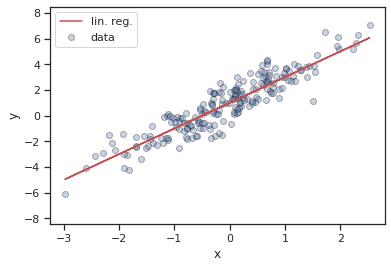

In [ ]:
# Plot subsampled data and liner regression
def plot(df=df, result=result, sample_size=200):
  df = df.sample(n=sample_size)
  plt.scatter(df['x'], df['y'], label='data', alpha=0.3, edgecolors='black')
  plt.plot(df['x'], result.predict(df['x']), c='r', label='lin. reg.')
  plt.ylim((-max(abs(df['y']))*1.2, max(abs(df['y']))*1.2))
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.show()

plot()

Because $R^2$ is a random variable, we shall now run a Monte Carlo simulation of $R^2$ for different sample sizes ($50$, $10^2$, $10^3$, and $10^4$). The number of simulations for each sample size is fixed to $500$.

In [ ]:
# Compute R2
def sample_R2(sample_size=50, df=df):
  model_n = ols(formula = 'y ~ x + 1', data=df.sample(n=sample_size))
  result_n = model_n.fit()
  # return R2
  return result_n.rsquared

In [ ]:
# number of simulations
n_sim = 500
# Data Frame containing all computed R2's
R2_frame = pd.DataFrame(columns=['n = 50', 'n = 100','n = 1000', 'n = 10000'], index=(range(0,n_sim))).astype(float)
# Simulation
for sim_i in range(n_sim):
  for sample_size in [50, 100, 1000, 10000]:
    R2_frame['n = '+str(sample_size)].loc[sim_i] = sample_R2(sample_size=sample_size) 

From the first linear regression on the full dataset, we know that the true $R^2$ is $0.8$ when $n \rightarrow \infty$. That is $\mathbb{E}(R^2) = 0.8$. Let us look into convergence of $R^2$ as the sample size grows.

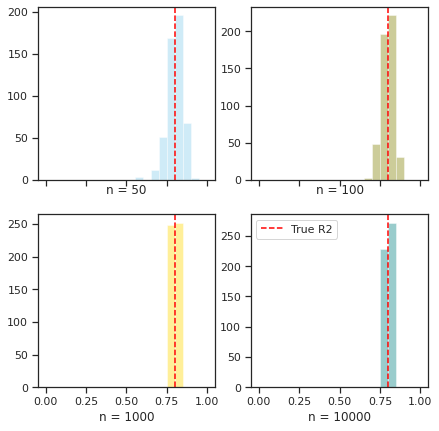

In [ ]:
# Plot histograms of R2 for n_sim MC simulations for four sample size: (50, 100, 1000, 10000)
def histograms(R2_frame=R2_frame):
  f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
  # n = 50
  sns.distplot(R2_frame['n = 50'], bins=20, color="skyblue", ax=axes[0, 0], kde=False, rug=False, hist_kws={"range": [0,1]})
  axes[0,0].axvline(R2, color='red', linestyle='--', label='True R2')
  # n = 100
  sns.distplot(R2_frame['n = 100'], bins=20, color="olive", ax=axes[0, 1], kde=False, rug=False, hist_kws={"range": [0,1]})
  axes[0,1].axvline(R2, color='red', linestyle='--', label='True R2')
  # n = 1000
  sns.distplot(R2_frame['n = 1000'], bins=20, color="gold", ax=axes[1, 0], kde=False, rug=False, hist_kws={"range": [0,1]})
  axes[1,0].axvline(R2, color='red', linestyle='--', label='True R2')
  # n = 10000
  sns.distplot(R2_frame['n = 10000'], bins=20, color="teal", ax=axes[1, 1], kde=False, rug=False, hist_kws={"range": [0,1]})
  axes[1,1].axvline(R2, color='red', linestyle='--', label='True R2')
  # 
  plt.legend()
  plt.show()

histograms()

We observe that $R^2$ *fastly* converges to the expected values $0.8$ as sample population grows. The expected $R^2$ is marked by the red dashed line. Even though it is sample dependant, $R^2$ gives a "good" measure of the linear model fit.

## Extremistan

Let us now examine the model 
$$Y = a+ b X + \epsilon\,,$$
where the independent variable $X$ is again a standard normal, $X\sim\mathcal{N}(0,1)$, and the error term $\epsilon$ is power low distributed with $\mathbb{E} (\epsilon) = 0$ and $\mathbb{E} (\epsilon^2) <+\infty$. Let us fix $a=1$ and $b=20$. Let $\epsilon$ be a T-Student random variable with $1.1$ degrees of freedom. Similar results can be obtained for the Cauchy (Student T-distribution with $1$ degree of freedom) and Pareto distribution.

In [ ]:
# (1) Student-T error RV
error = t.rvs(1.1, size=n)
# (2) Cauchy error RV 
# error = np.tan(np.pi*(np.random.uniform(0, 1, n)-0.5))
# (3) Pareto error RV
# error = -3 + (1-np.random.uniform(0, 1, n))**(-2/3)

# Dependent RV
y = 1 + 20*x + error
# Generate Data Frame of n realizations
df = pd.DataFrame({'y':y,'x':x})

The standard linear regression model for estimation of the coefficiants $a$ and $b$ is given as follows.

In [ ]:
# Linear Regression Model
model = ols(formula = 'y ~ x + 1', data=df)
result = model.fit()
prediction = result.predict() # make the predictions by the model

# Print out the statistics
print(result.summary())
R2 = result.rsquared

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3814.
Date:                Tue, 30 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:58:27   Log-Likelihood:            -7.1900e+06
No. Observations:             1000000   AIC:                         1.438e+07
Df Residuals:                  999998   BIC:                         1.438e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7394      0.321      2.304      0.0

Observe that $R^2$ is effectively $0$. 

Let us plot the sampled dataset and the resulting linear regression.




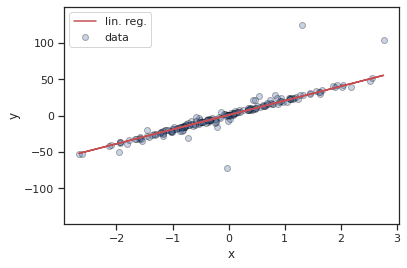

In [ ]:
plot(df=df, result=result)

As in Mediocristan, we run $500$ simulations for each of different sample sizes ($50$, $10^2$, $10^3$, and $10^4$) and visualize distribution of $R^2$.

In [ ]:
R2_frame = pd.DataFrame(columns=['n = 50', 'n = 100','n = 1000', 'n = 10000'], index=(range(0,n_sim))).astype(float)
# Simulation
for sim_i in range(n_sim):
  for sample_size in [50, 100, 1000, 10000]:
    R2_frame['n = '+str(sample_size)].loc[sim_i] = sample_R2(sample_size=sample_size, df=df) 

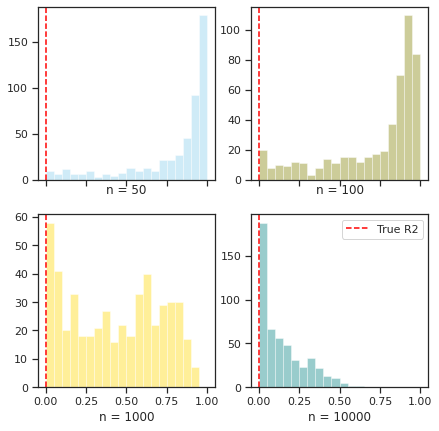

In [ ]:
histograms(R2_frame=R2_frame)

Notice that even for relatively large sample size the coefficient of determination $R^2$ gives a deceptive quality of the model. Only for *extremely* large sample size do we see a convergence of $R^2$ to its true value $0$. This  implies that in practice, in Extremistan, the linear regression is estimating a pure noise and the relations established by linear regression should not be taken seriously.

For an intresting and important article about the relation between IQ and wealth see Taleb's article [_IQ is largely a pseudoscientific swindle_](https://medium.com/incerto/iq-is-largely-a-pseudoscientific-swindle-f131c101ba39).